# PennFudan Dataset Feature Extraction

In [1]:
import os
import numpy as np
import torch
from torch import nn
from torchvision import transforms
from torchvision.ops.boxes import box_iou
import matplotlib.pyplot as plt
from PIL import Image
import cv2
import pandas as pd
from glob import glob

In [2]:
ann = pd.read_csv('./PennFudanPed/Annotation/PennFudanVia.csv')
ann

,filename,file_size,file_attributes,region_count,region_id,region_shape_attributes,region_attributes
0,../PennFudanPed/PNGImages/FudanPed00001.png,-1,{},2,0,"{""name"":""rect"",""x"":159,""y"":181,""width"":142,""he...","{""type"":""Pedestrian"",""occluded"":{}}"
1,../PennFudanPed/PNGImages/FudanPed00001.png,-1,{},2,1,"{""name"":""rect"",""x"":419,""y"":170,""width"":115,""he...","{""type"":""Pedestrian""}"
2,../PennFudanPed/PNGImages/FudanPed00002.png,-1,{},2,0,"{""name"":""rect"",""x"":67,""y"":92,""width"":123,""heig...","{""type"":""Pedestrian""}"
3,../PennFudanPed/PNGImages/FudanPed00002.png,-1,{},2,1,"{""name"":""rect"",""x"":145,""y"":99,""width"":82,""heig...","{""type"":""Pedestrian"",""occluded"":{""true"":true},..."
4,../PennFudanPed/PNGImages/FudanPed00003.png,-1,{},3,0,"{""name"":""rect"",""x"":304,""y"":134,""width"":142,""he...","{""type"":""Pedestrian""}"
...,...,...,...,...,...,...,...
529,../PennFudanPed/PNGImages/PennPed00094.png,-1,{},2,1,"{""name"":""rect"",""x"":28,""y"":274,""width"":93,""heig...","{""type"":""Pets"",""occluded"":{},""carry-on"":{}}"
530,../PennFudanPed/PNGImages/PennPed00095.png,-1,{},2,0,"{""name"":""rect"",""x"":192,""y"":49,""width"":107,""hei...","{""type"":""Pedestrian"",""carry-on"":{""hand-bag"":tr..."
531,../PennFudanPed/PNGImages/PennPed00095.png,-1,{},2,1,"{""name"":""rect"",""x"":319,""y"":54,""width"":112,""hei...","{""type"":""Pedestrian""}"
532,../PennFudanPed/PNGImages/PennPed00096.png,-1,{},2,0,"{""name"":""rect"",""x"":5,""y"":37,""width"":96,""height...","{""type"":""Pedestrian"",""carry-on"":{""backpack"":tr..."


In [3]:
import json
json.loads(ann.loc[3, 'region_attributes'])

{'type': 'Pedestrian',
 'occluded': {'true': True},
 'carry-on': {'backpack': True}}

# Dataset

In [4]:
TYPES = ['Pedestrian', 'Cyclist', 'Pets']
CARRY_ONS = ['backpack', 'shoulder-bag', 'hand-bag', 'luggage', 'umbrella', 'misc']

In [11]:
class PennFudanDataset(torch.utils.data.Dataset):
    def __init__(self, root, transform):
        self.root = root
        # load all image files, sorting them to
        # ensure that they are aligned
        self.ann = pd.read_csv(os.path.join(root, 'Annotation', 'PennFudanVia.csv'))
        # standard transform
        self.raw_transforms = transforms.Compose([
            # fixed transform
            transforms.ToTensor(),
            transforms.ConvertImageDtype(torch.float)
        ])
        self.transforms = transforms.Compose(self.raw_transforms.transforms + transform.transforms)
        self.types = TYPES
        self.carry_ons = CARRY_ONS

    def __getitem__(self, idx):
        # load images
        img_path = os.path.join(self.root, 'PNGImages', self.ann.loc[idx, 'filename'].split('/')[-1])
        img = Image.open(img_path).convert('RGB')
        # get bounding box coordinates for each mask
        num_objs = self.ann.loc[idx, 'region_count']
        box = json.loads(self.ann.loc[idx, 'region_shape_attributes'])
        attr = json.loads(self.ann.loc[idx, 'region_attributes'])

        t = [int(self.types.index(attr['type']))]
        o = [int(attr.get('occluded', {}).get('true', False))]
        c = [int(k in attr.get('carry-on', {}).keys()) for k in self.carry_ons]

        # normalize the boxes
        width, height = img.size

        tlx = box['x']
        tly = box['y']
        brx = tlx + box['width']
        bry = tly + box['height']
        box = torch.as_tensor([tlx, tly, brx, bry], dtype=torch.float32)

        target = {}
        target['id'] = torch.as_tensor(idx, dtype=torch.int16)
        target['raw'] = self.raw_transforms(img)
        target['box'] = box / torch.tensor([width, height] * 2)
        target['labels'] = torch.as_tensor(np.concatenate([t, o, c]), dtype=torch.uint8)

        if self.transforms is not None:
            img = self.transforms(img)

        return img, target

    def __len__(self):
        return len(self.ann)

In [22]:
def get_object(image, bb, transform=None):
    w, h = image.shape[1], image.shape[2]
    bb = torch.floor(bb * torch.tensor([h, w, h, w])).int()

    ped = image[:, bb[1]:bb[3], bb[0]:bb[2]].clone()
    if transform:
        ped = transform(ped)

    return ped

In [18]:
def typeof(yt):
    t = yt['labels'][0]
    return TYPES[t]

def is_occluded(yt):
    o = yt['labels'][1]
    return o == 1

def carry_ons(yt):
    c = yt['labels'][2:]
    return ', '.join([CARRY_ONS[i] for i in range(len(c)) if c[i] == 1])

In [23]:
# construct dataset
scale = (224, 224)
mean = (0.485, 0.456, 0.406)
std = (0.229, 0.224, 0.225)

transform = transforms.Compose([
    # transforms.Resize(scale, antialias=True),
    transforms.Normalize(mean, std)
])

root = './PennFudanPed'
dataset = PennFudanDataset(root, transform)

len(dataset)

534

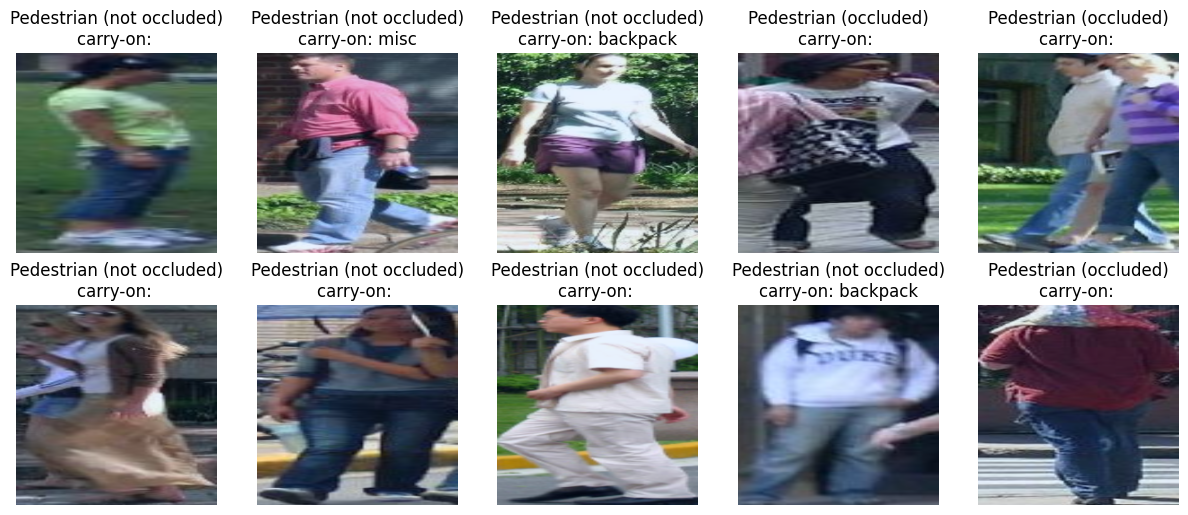

In [26]:
idx = np.random.choice(range(len(dataset)), 10, replace=False)
fig, ax = plt.subplots(2, 5, figsize=(15, 6))
t = transforms.Resize(scale, antialias=True)

for i, ii in enumerate(idx):
    Xt, yt = dataset[ii]
    title = '{} ({})\n{}'.format(
        typeof(yt), 'occluded' if is_occluded(yt) else 'not occluded',
        'carry-on: ' + carry_ons(yt)
    )
    ped = get_object(Xt, yt['box'], t).numpy().transpose(1, 2, 0)
    ped -= ped.min()
    ped /= ped.max()
    ax[i//5][i%5].imshow(ped)
    ax[i//5][i%5].axis('off')
    ax[i//5][i%5].set_title(title)

## Features

In [27]:
from torchvision.models import resnet50, ResNet50_Weights

class Featurizer(nn.Module):
    def __init__(self, model, weights, num_layers=6):
        super().__init__()
        model = model(weights=weights)
        # To register a list of nn.Modules, wrap them up with nn.ModuleList:
        # https://pytorch.org/docs/stable/generated/torch.nn.ModuleList.html
        # Compared to nn.Sequential that seals the modules as one, nn.ModuleList
        # provides easier access to intermediate layers
        self.layers = nn.ModuleList(list(model.children()))
        self.num_layers = num_layers

    def forward(self, x):
        # feed forward through a specific number of layers
        for layer in self.layers[:self.num_layers]:
            x = layer(x)
        return x

In [38]:
featurizer = Featurizer(resnet50, ResNet50_Weights.DEFAULT, -1).cuda()
Xt = get_object(Xt, yt['box'], t)
feat = featurizer(Xt.cuda().unsqueeze(0))
print(Xt.shape, feat.shape)

torch.Size([3, 224, 224]) torch.Size([1, 2048, 1, 1])


### ViaCrops

In [30]:
from glob import glob

root = 'PennFudanPed/ViaCrops/'

train_imgs = sorted(glob(root + 'train/*.png'))
test_imgs = sorted(glob(root + 'test/*.png'))
len(train_imgs), len(test_imgs)

(434, 100)

In [33]:
indices = [int(img.split('/')[-1].split('.')[0]) for img in train_imgs]
train_set = torch.utils.data.Subset(dataset, indices)
test_set = torch.utils.data.Subset(dataset, [i for i in range(len(dataset)) if i not in indices])
len(train_set), len(test_set)

(434, 100)

In [ ]:
feats = []
for i, (X, y) in enumerate(train_set):
    ped = get_object(X, y['box'], t).unsqueeze(0).cuda()
    feats.append(featurizer(ped).detach().squeeze().cpu().numpy())

feats = np.stack(feats)
np.save(root + 'train_feats.npy', feats)
print(feats.shape)

feats = []
for i, (X, y) in enumerate(test_set):
    ped = get_object(X, y['box'], t).unsqueeze(0).cuda()
    feats.append(featurizer(ped).detach().squeeze().cpu().numpy())

feats = np.stack(feats)
np.save(root + 'test_feats.npy', feats)
print(feats.shape)

### ViaCropsNOC

In [48]:
from glob import glob

root = 'PennFudanPed/ViaCropsNOC/'

train_imgs = sorted(glob(root + 'train/*.png'))
test_imgs = sorted(glob(root + 'test/*.png'))
len(train_imgs), len(test_imgs)

(200, 334)

In [49]:
indices = [int(img.split('/')[-1].split('.')[0]) for img in train_imgs]
train_set = torch.utils.data.Subset(dataset, indices)
test_set = torch.utils.data.Subset(dataset, [i for i in range(len(dataset)) if i not in indices])
len(train_set), len(test_set)

(200, 334)

In [51]:
feats = []
featurizer.eval()
for i, (X, y) in enumerate(train_set):
    ped = get_object(X, y['box'], None).unsqueeze(0).cuda()
    feats.append(featurizer(ped).detach().squeeze().cpu().numpy())

feats = np.stack(feats)
np.save(root + 'train_feats.npy', feats)
print(feats.shape)

feats = []
for i, (X, y) in enumerate(test_set):
    ped = get_object(X, y['box'], None).unsqueeze(0).cuda()
    feats.append(featurizer(ped).detach().squeeze().cpu().numpy())

feats = np.stack(feats)
np.save(root + 'test_feats.npy', feats)
print(feats.shape)

(200, 2048)
(334, 2048)
